### MACHINE LEARNING PIPELINE - TITANIC

DANIEL CIFUENTES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(str(data.shape))

(891, 12)


In [12]:
#Eliminamos el id de cada pasajero
data.drop('PassengerId', axis=1, inplace=True)

In [13]:
print(str(data.shape))

(891, 11)


### Analisis de Datos

In [9]:
## Analisis de la data
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [14]:
var_with_na = [var for var in data.columns if(data[var].isnull().sum() > 0)]
len(var_with_na)

3

In [15]:
data[var_with_na].isnull().mean().sort_values(ascending=False)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64

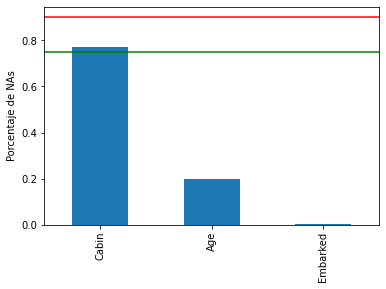

In [18]:
data[var_with_na].isnull().mean().sort_values(ascending=False).plot.bar()
plt.ylabel("Porcentaje de NAs")
plt.axhline(y=0.9, color="r")
plt.axhline(y=0.75, color="g")

In [19]:
def na_impact_over_target(df, Xvar, Yvar):
    df = data.copy()
    df[Xvar] = np.where(df[Xvar].isnull(), 1, 0)
    temp = df.groupby(Xvar)[Yvar].agg(['mean', 'std'])
    temp.plot(kind="barh", y="mean", xerr="std", legend=False, title=Yvar)
    plt.show()

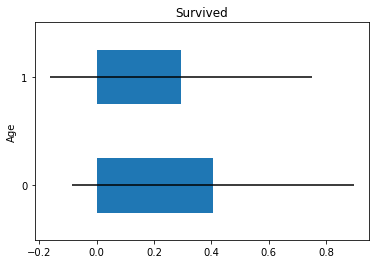

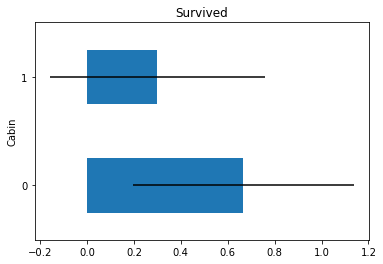

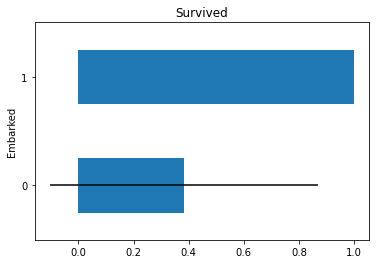

In [20]:
for var in var_with_na:
    na_impact_over_target(data, var, 'Survived')

Vemos que la variable "Cabin" muestra que más de la mitad de los registros están en blanco, por lo que podemos descartar dicha variable (además que es una variable categórica).
Por otro lado, la variable de "Embarked" tiene menos del 1% de NAs, por lo que podemos omitir también dicha variable.

In [21]:
data.drop('Embarked', axis=1, inplace=True)
data.drop('Cabin', axis=1, inplace=True)

In [22]:
print(str(data.shape))

(891, 9)
